# 3. Extract Transforms Use Cases

In this notebook, I will show some use cases for extracting out the [transformations](https://vega.github.io/vega-lite/docs/transform.html) in a Vega Lite spec and computing them in the database instead of on the client. 


In [1]:
import altair as alt
import ibis
import omnisci_renderer

In [2]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Omnisci [Vega Tutorial](https://www.omnisci.com/docs/latest/6_vegaTutorials.html)

First, let's go through the omnisci vega tutorial, but doing this all client side. We will that results don't look quite right since we will only get back a subset of rows from the backend, since there are too many.

This makes the case for doing aggregates in the backend before sending the data.

In [5]:
conn = ibis.mapd.connect(
    host='metis.mapd.com', user='mapd', password='HyperInteractive',
    port=443, database='mapd', protocol= 'https'
)
t = conn.table("flights_donotmodify")

In [12]:
t.aggregate(t.count().name("count_*")).execute()

Exception: Exception: Parse failed: Encountered "*" at line 1, column 26.
Was expecting one of:
    <EOF> 
    "ORDER" ...
    "LIMIT" ...
    "OFFSET" ...
    "FETCH" ...
    "FROM" ...
    "," ...
    "UNION" ...
    "INTERSECT" ...
    "EXCEPT" ...
    "MINUS" ...
    : SELECT count(*) AS count_*
FROM flights_donotmodify
LIMIT 10000

'json'

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


'default'

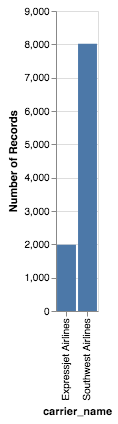

'extract-json'

<IPython.core.display.JSON object>

'extract'

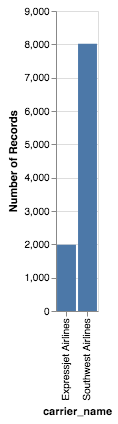

'extract-ibis'

In [4]:
c = alt.Chart(t[t.carrier_name]).mark_bar().encode(
    x='carrier_name',
    y='count()'
)
omnisci_renderer.display_chart(c)

In [30]:
alt.renderers.enable('extract-json')
c

<IPython.core.display.JSON object>

In [6]:
expr = t[t.flight_dayofmonth, t.flight_month, t.depdelay]

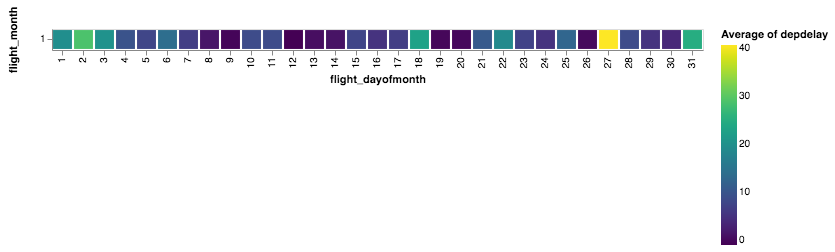

In [11]:
alt.renderers.enable('default')

c = alt.Chart(t[t.flight_dayofmonth, t.flight_month, t.depdelay]).mark_rect().encode(
    x='flight_dayofmonth:O',
    y='flight_month:O',
    color='average(depdelay)'
)
c

In [12]:
alt.renderers.enable('extract-json')
c

<IPython.core.display.JSON object>

In [20]:
expr['depdelay'].ipynb_checkpoints/

ref_0
DatabaseTable[table]
  name: flights_donotmodify
  schema:
    flight_year : int16
    flight_month : int16
    flight_dayofmonth : int16
    flight_dayofweek : int16
    deptime : int16
    crsdeptime : int16
    arrtime : int16
    crsarrtime : int16
    uniquecarrier : string
    flightnum : int16
    tailnum : string
    actualelapsedtime : int16
    crselapsedtime : int16
    airtime : int16
    arrdelay : int16
    depdelay : int16
    origin : string
    dest : string
    distance : int16
    taxiin : int16
    taxiout : int16
    cancelled : int16
    cancellationcode : string
    diverted : int16
    carrierdelay : int16
    weatherdelay : int16
    nasdelay : int16
    securitydelay : int16
    lateaircraftdelay : int16
    dep_timestamp : timestamp
    arr_timestamp : timestamp
    carrier_name : string
    plane_type : string
    plane_manufacturer : string
    plane_issue_date : date
    plane_model : string
    plane_status : string
    plane_aircraft_type : string


In [9]:
print(expr.aggregate(expr.count().name('count'), by=['flight_dayofmonth', 'flight_month']).compile())

SELECT "flight_dayofmonth", "flight_month", count(*) AS "count"
FROM (
  SELECT "flight_dayofmonth", "flight_month", "depdelay"
  FROM flights_donotmodify
) t0
GROUP BY flight_dayofmonth, flight_month


In [ ]:
expr.aggregate()

In [33]:
display("hi")

'hi'